## Module 1

         Date      Time  Global_active_power  Global_reactive_power  Voltage  \
0  16/12/2006  17:24:00                4.216                  0.418   234.84   
1  16/12/2006  17:25:00                5.360                  0.436   233.63   
2  16/12/2006  17:26:00                5.374                  0.498   233.29   
3  16/12/2006  17:27:00                5.388                  0.502   233.74   
4  16/12/2006  17:28:00                3.666                  0.528   235.68   

   Global_intensity  Sub_metering_1  Sub_metering_2  Sub_metering_3  
0              18.4             0.0             1.0            17.0  
1              23.0             0.0             1.0            16.0  
2              23.0             0.0             2.0            17.0  
3              23.0             0.0             1.0            17.0  
4              15.8             0.0             1.0            17.0  
(48424, 9)
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 48424 entries, 0 to 48423
Data columns

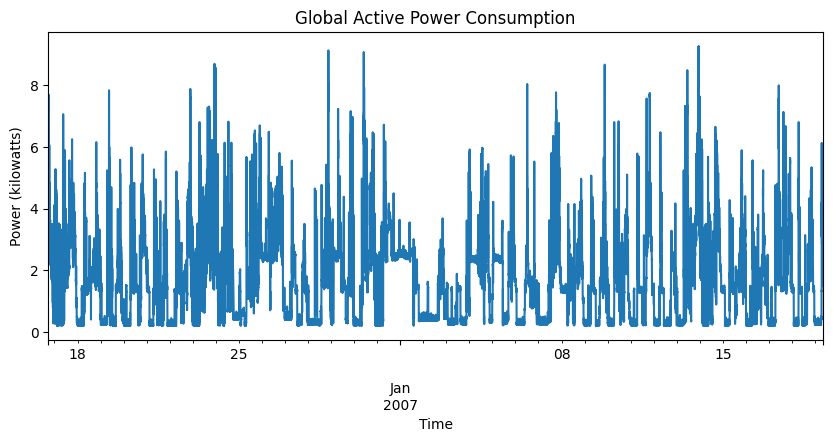

In [9]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

# Define the column names explicitly
column_names = [
    'Date', 'Time', 'Global_active_power', 'Global_reactive_power',
    'Voltage', 'Global_intensity', 'Sub_metering_1', 'Sub_metering_2',
    'Sub_metering_3'
]

data = pd.read_csv(
    'household_power_consumption.txt',
    sep=';',
    na_values='?',
    names=column_names,   # Explicitly provide column names
    header=None,          # Tell pandas not to look for a header in the file
    skiprows=1,           # Skip the actual header row (which would be the first data row now)
    encoding='latin1',
    engine='python'       # Using python engine for robust parsing
)

print(data.head())
print(data.shape)
print(data.info())
print(data.describe())
data[['Date', 'Time']].isnull().sum()
data['Datetime'] = pd.to_datetime(
    data['Date'] + ' ' + data['Time'],
    format='%d/%m/%Y %H:%M:%S'
)

data.head()
data.set_index('Datetime', inplace=True)
data['Global_active_power'].plot(figsize=(10,4))
plt.title("Global Active Power Consumption")
plt.xlabel("Time")
plt.ylabel("Power (kilowatts)")
plt.show()


##Module 2

In [15]:
data.isnull().sum()
data.ffill(inplace=True) # Updated: Using ffill() directly
Q1 = data['Global_active_power'].quantile(0.25)
Q3 = data['Global_active_power'].quantile(0.75)
IQR = Q3 - Q1

data = data[
    (data['Global_active_power'] >= Q1 - 1.5 * IQR) &
    (data['Global_active_power'] <= Q3 + 1.5 * IQR)
]

# Drop non-numeric columns 'Date' and 'Time' before resampling
data_numeric = data.drop(columns=['Date', 'Time'])
hourly_data = data_numeric.resample('h').mean() # Updated: Using 'h' instead of 'H'
daily_data = data_numeric.resample('D').mean()

from sklearn.preprocessing import MinMaxScaler

scaler = MinMaxScaler()
hourly_data[['Global_active_power']] = scaler.fit_transform(
    hourly_data[['Global_active_power']]
)

print(hourly_data.head())
from sklearn.preprocessing import MinMaxScaler

scaler = MinMaxScaler()
hourly_data[['Global_active_power']] = scaler.fit_transform(
    hourly_data[['Global_active_power']]
)

print(hourly_data.head())
train_size = int(len(hourly_data) * 0.7)
val_size = int(len(hourly_data) * 0.15)

train = hourly_data[:train_size]
val = hourly_data[train_size:train_size + val_size]
test = hourly_data[train_size + val_size:]

print("Train size:", train.shape)
print("Validation size:", val.shape)
print("Test size:", test.shape)


                     Global_active_power  Global_reactive_power     Voltage  \
Datetime                                                                      
2006-12-16 17:00:00             0.854931               0.249818  234.887879   
2006-12-16 18:00:00             0.718847               0.075709  234.785091   
2006-12-16 19:00:00             0.721920               0.085233  233.232500   
2006-12-16 20:00:00             0.691804               0.075100  234.071500   
2006-12-16 21:00:00             0.643291               0.076667  237.158667   

                     Global_intensity  Sub_metering_1  Sub_metering_2  \
Datetime                                                                
2006-12-16 17:00:00         17.042424             0.0        0.575758   
2006-12-16 18:00:00         14.538182             0.0        4.181818   
2006-12-16 19:00:00         14.503333             0.0        1.433333   
2006-12-16 20:00:00         13.916667             0.0        0.000000   
2006-12-